In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib import rc
from ellipse import LsqEllipse
from math import comb
from matplotlib.patches import Ellipse
import scipy.optimize as sco
from scipy.optimize import fmin
from scipy.optimize import curve_fit
import scipy
import json
import glob
import os
import allantools
from tqdm.notebook import trange, tqdm
import warnings
warnings.filterwarnings("ignore")
rc('font',**{'family':'sans-serif','sans-serif':['Fira Sans'],'size':14,'style':'normal'})
rc('text', usetex=False)


BLUE = 'xkcd:pastel blue'
RED = 'xkcd:pastel red'
GREEN = 'xkcd:pastel green'
YELLOW ='xkcd:pastel yellow'
PURPLE = 'xkcd:pastel purple'
DBLUE = 'xkcd:light navy blue'
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=[BLUE, RED, GREEN, YELLOW,PURPLE,DBLUE])




f0 = 429e12
h_const = 6.626e-34
og_directory = os.getcwd()

from scipy.optimize import curve_fit

def fit_sine(t, y, yerr=None):
    """
    Fit y(t) ≈ A * sin(2π f t + phi) + offset

    Parameters
    ----------
    t : array
        Time (or x) values.
    y : array
        Data values.
    yerr : array, optional
        1σ errors on y. If provided, weighted least-squares is used.

    Returns
    -------
    dict : best-fit parameters, 1σ errors, and model function.
    """
    def model(t, A, f, phi, offset):
        return A * np.sin(2*np.pi*f*t + phi) + offset

    # --- crude guesses ---
    guess_A = (np.max(y) - np.min(y)) / 2
    guess_offset = np.mean(y)
    
    # frequency guess from FFT
    freqs = np.fft.rfftfreq(len(t), d=(t[1]-t[0]))
    fft_mag = np.abs(np.fft.rfft(y - guess_offset))
    guess_f = freqs[np.argmax(fft_mag[1:]) + 1] if len(freqs) > 1 else 1.0
    
    guess_phi = 0
    p0 = [guess_A, guess_f, guess_phi, guess_offset]

    # --- fit ---
    popt, pcov = curve_fit(
        model, t, y, p0=p0,
        sigma=yerr, absolute_sigma=True if yerr is not None else False
    )
    perr = np.sqrt(np.diag(pcov))

    names = ["amplitude", "frequency", "phase", "offset"]

    return {
        name: val for name, val in zip(names, popt)
    } | {
        f"{name}_err": err for name, err in zip(names, perr)
    } | {
        "model": lambda t: model(t, *popt)
    }


def allan_errors(frac_frequencies, allan_dev, tau, ramsey_time, dead_time,
                     method="oadev", noise_process="whitefm"):

        #Getting our common varibles needed
        n = len(frac_frequencies)
        m = tau/(ramsey_time+dead_time)      
        
        #Calculate edf for chi-squared calculation based on noise process
        if method == "oadev":
            if noise_process == "whitepm":
                edf = (n + 1)*(n - 2*m)/(2*(n - m))
            elif noise_process == "whitefm":
                edf = (4*m**4/(4*m**2+5))*(3*(n-1)/(2*m) - 2*(n-2)/n)
            else:
                print("Unable to calculate error for given error type")
                
        if method == "totdev":
            if noise_process == "whitepm" or noise_process=="whitefm":
                b = 1.50
                c= 0.0
                big_t = len(frac_frequencies)*(ramsey_time+dead_time) #Total measurement time
                edf = b*(big_t/tau) - c
            else:
                print("Unable to calculate error for given error type")
                
        else:
            if noise_process == "whitepm" or noise_process == "whitefm":
                edf = (n + 1)*(n - 2*m)/(2*(n - m))
            else:
                print("Unable to calculate error for given error type")
        
        #Calculating Chi Squared Table Values
        lower_chi = scipy.stats.chi2.isf(0.16, df=edf)
        upper_chi = scipy.stats.chi2.isf(0.84, df=edf)
        #Making sure to use variance in our calculations and report our CI in terms of deviataion
        lower_cutoff = allan_dev - np.sqrt(allan_dev**2*(edf/lower_chi))
        upper_cutoff = np.sqrt(allan_dev**2*(edf/upper_chi)) - allan_dev
        
        return(lower_cutoff, upper_cutoff)    



def monoExp(x,t):
    return np.exp(-(1/t) * x) 

def monoExpN(x,t,c):
    return c*np.exp(-(1/t) * x) 


def get_parent_dir(directory):
    import os
    return os.path.dirname(directory)
def QPN(tau,N,C,t_ramsey,t_dead):
    QPN = np.sqrt(2)/(2*np.pi*f0*C*t_ramsey)*(np.sqrt((t_ramsey+t_dead)/(N*(tau))))
    return QPN
def gaussian(x, mu, sig):
    return (
        1.0 / (np.sqrt(2.0 * np.pi) * sig) * np.exp(-np.power((x - mu) / sig, 2.0) / 2)
    )
def likelihood(X,Y,P1,P2,n):
    N1 = X*n
    l1 = gaussian(N1,P1*n,np.sqrt(n*P1*(1-P1)))
    N2 = Y*n
    l2 = gaussian(N2,P2*n,np.sqrt(n*P2*(1-P2)))
    return l1*l2
        
    
def make_ellipse(phi,C1,xc,yc):
    phase_com = np.linspace(0,2*np.pi,200)
    P1 = 1/2*(1+np.cos(phase_com))
    P2 = 1/2*(1+np.cos(phase_com+phi))   
    return P1,P2

def likelihood_sum(phi, C1, C2, X, Y, xc, yc, n1, n2, phase_jitter_std = 0 ):
    phase_com = np.linspace(0, 2 * np.pi, 20000)

    # Effective contrasts from jitter
    C1_eff = np.abs(C1) * np.exp(-0.5 * phase_jitter_std**2)
    C2_eff = np.abs(C2) * np.exp(-0.5 * phase_jitter_std**2)

    # Raw P1, P2
    P1 = 0.5 * (1 + C1_eff * np.cos(phase_com))
    P2 = 0.5 * (1 + C2_eff * np.cos(phase_com + phi))

    # Clip to avoid exact 0 or 1
    eps = 1e-10
    P1 = np.clip(P1, eps, 1 - eps)
    P2 = np.clip(P2, eps, 1 - eps)

    # Repeat shapes
    X = np.repeat(X[:, None], len(phase_com), axis=1)
    Y = np.repeat(Y[:, None], len(phase_com), axis=1)
    P1 = np.repeat(P1[None, :], X.shape[0], axis=0)
    P2 = np.repeat(P2[None, :], Y.shape[0], axis=0)

    # QPN variance (in counts)
    sigma1_qpn = np.sqrt(n1 * P1 * (1 - P1))
    sigma2_qpn = np.sqrt(n2 * P2 * (1 - P2))

    # Jitter variance (in counts)
    # derivative dP/dphi = -0.5 * C_eff * sin(...)
    jitter1 = 0.25 * (C1_eff**2) * (np.sin(phase_com)**2) * (n1**2) * (phase_jitter_std**2)
    jitter2 = 0.25 * (C2_eff**2) * (np.sin(phase_com + phi)**2) * (n2**2) * (phase_jitter_std**2)

    # Match shapes for broadcasting
    jitter1 = np.repeat(jitter1[None, :], X.shape[0], axis=0)
    jitter2 = np.repeat(jitter2[None, :], Y.shape[0], axis=0)

    # Total sigma (counts)
    sigma1 = np.sqrt(sigma1_qpn**2 + jitter1)
    sigma2 = np.sqrt(sigma2_qpn**2 + jitter2)

    sigma1 = np.where(sigma1 == 0, 1e-12, sigma1)
    sigma2 = np.where(sigma2 == 0, 1e-12, sigma2)

    # Gaussian likelihoods
    likes1 = gaussian(X * n1, P1 * n1, sigma1)
    likes2 = gaussian(Y * n2, P2 * n2, sigma2)
    likes = likes1 * likes2

    # Log likelihood
    loglikes = np.log(np.sum(likes, axis=1) + 1e-300)
    total_likelihood = np.sum(loglikes)
    return total_likelihood


def inverse(x, c):
    return x**(-.5) * c
    


def MLE_optimized_err(data, n1, n2, offset, pll_noise = 0 , g=False, guess=None, cov=False):
    import numpy as np
    import scipy.optimize as sco

    P1 = data[:, 0]
    P2 = data[:, 1]

    # Objective function: negative log-likelihood
    def objective(args):
        [p1] = args
        return -likelihood_sum(p1, 1, 1, np.array(P1), np.array(P2), 0.5, 0.5, n1, n2, phase_jitter_std = pll_noise)

    # Initial guess
    if not g or guess is None:
        guess1 = np.array([offset])
    else:
        guess1 = guess + 1e-4  # Replace epsilon with 1e-4 if not defined

    # Optimization
    opt = sco.minimize(
        objective,
        guess1,
        method='Nelder-Mead',
        options={'disp': False, 'xatol': 1e-9}
    )

    # Wrap and clean phase estimate
    phi_MLE = np.abs(opt.x[0])
    if phi_MLE > np.pi:
        phi_MLE = 2 * np.pi - phi_MLE

    # Compute standard error (if requested)
    if cov:
        h = 1e-5
        try:
            f_plus  = objective([phi_MLE + h])
            f_minus = objective([phi_MLE - h])
            f0      = objective([phi_MLE])
            second_deriv = (f_plus - 2 * f0 + f_minus) / (h ** 2)

            if second_deriv <= 0 or np.isnan(second_deriv):
                phase_jitter_std = np.nan
                print("⚠️ Warning: curvature non-positive or NaN — error estimate invalid.")
            else:
                phase_jitter_std = np.sqrt(1 / second_deriv)
        except:
            phase_jitter_std = np.nan
            print("⚠️ Error computing second derivative — returning NaN for uncertainty.")

        return phi_MLE, phase_jitter_std

    return np.array([phi_MLE])

    
    
def adevffd(frac_freq_diff,t_ramsey,t_dead,N,C):
    t= np.linspace(1,150)
    r = 1/(t_ramsey+t_dead)
    t= np.linspace(1,len(frac_freq_diff)/r)
    #(t2, ad, ade, adn) = allantools.oadev(frac_freq_diff/f0, rate=r, data_type="freq", taus=t)
    (t2, ad, ade, adn) = allantools.adev(frac_freq_diff, rate=r, data_type="freq", taus=t)
    popt, pcov = sco.curve_fit(inverse, t2, ad,sigma = ade,p0 = [1e-17],absolute_sigma = True )
    return (popt[0],np.sqrt(pcov[0][0]))

def QPN_scale(C,phi):
    N =100 
    theta = np.linspace(0+10e-2,2*np.pi+10e-2,N)
    x = C/2*np.cos(theta)
    y = C/2*np.cos(theta+phi)
    var_x = (1/2-x)*(1/2+x)
    var_y = (1/2-y)*(1/2+y)
    integral = np.sum(1/(var_x/np.sin(theta)**2+var_x/np.sin(theta+phi)**2))/100    
    return 2/integral


def jackknife_ffd(data,t_ramsey,t_dead,n1,n2,guess = None, g = False,phases = False):
    phi_i = []
    C_i = []
    guesses =[]
    for i in (range(len(data))):
        jk_data = np.delete(data,i,axis = 0)        
        [opt_jk,guess1] = MLE_optimized(jk_data,n1,n2,g= g, guess = guess)
        phi_D = opt_jk[0]
        guesses.append(guess1)
        
        phi_i.append(phi_D)
        C_i.append(opt_jk[1])
    guesses = np.transpose(np.array(guesses))
    
    phi_i = np.array(phi_i)
    shots = len(data)
    phi_jk_mean = np.mean(phi_i)*np.ones(shots)
    phi_jk_i = (phi_jk_mean*shots)-(phi_i*(shots-1))
    frac_freq_diff = np.array(phi_jk_i/t_ramsey/(2*np.pi))/f0
    
    if phases==True:
        if g:
            return [frac_freq_diff,phi_i,C_i,guess1]
        else:
            return [frac_freq_diff,phi_i,C_i]
    
    return frac_freq_diff


def jackknife_phi(data,n1,n2,offset):
    phi_i = []
    for i in (range(len(data))):
        jk_data = np.delete(data,i,axis = 0)        
        opt_jk= MLE_optimized(jk_data,n1,n2,offset)
        phi_i.append(opt_jk)

    
    phi_i = np.array(phi_i)
    return np.std(phi_i)

def QPN_sim(p,n,C=1):
    return np.random.binomial(n,p)/n


def dd_window(size, n_pi_pulses):
    """
    Evenly spaced window alternating between 1 and -1.
    
    Parameters
    ----------
    size : int
        Total length of the array.
    n_switches : int
        Number of times to switch sign.
    """
    # total number of segments
    segments = n_pi_pulses + 1
    
    # index for each point
    idx = np.arange(size)
    
    # figure out which segment each index belongs to
    seg = (idx * segments) // size   # integer division
    
    # alternate signs: start at +1, flip each segment
    return (-1) ** seg




In [2]:

d = 1e10
c = 3e8


def h(t,H,f,phi):
    return H*np.sin(2*np.pi*f*t+phi)

def gw(t0,T):
    ts = np.linspace(t0,t0+T,10000)
    s = 1/2*(h(ts)-h(ts+d/c))
    return (ts,s) 

def signal(t0,T=160,H= 1e-20,f = 1/160,phi = 0,dd_pi_pulses = 1):
    
    ts = np.linspace(t0,t0+T,10000)
    dt = ts[1]-ts[0]
    s = 1/2*(h(ts,H,f,phi)-h(ts+d/c,H,f,phi))
    s_bar = np.sum((1/T * s*dt)*dd_window(len(s),1))
    return s_bar



In [3]:
def optimal_bandwidth(linewidth, laser_power, qe):
    return np.sqrt(qe*laser_power*linewidth/(h_const*f0))

def laser_phase_noise(linewidth, laser_power, qe):
    # bandwidth = optimal_bandwidth(linewidth, laser_power, qe)
    bandwidth = optimal_bandwidth(linewidth, laser_power, qe)
    var_phi = h_const*f0*bandwidth/(qe*laser_power)+(linewidth/bandwidth)
    return np.sqrt(var_phi)
   
    

In [4]:
def total_measurement_time(T,n_points,avgs):
    t0 = np.linspace(0,T-T/n_points,n_points)
    t_set = []
    t_start = 0
    for t1 in t0:
        ts = ((t_start+np.arange(avgs)*T))
        t_set.append(ts)
        t_start = ts[-1]+T+T/n_points
    t_end = ts[-1]+T
    return (t_end/3600)



def estimate_phase(T,n_points,avgs,phi,N = 1e7,offset = np.pi/10):
    t0 = np.linspace(0,T-T/n_points,n_points)
    t_set = []
    t_start = 0
    for t1 in t0:
        ts = ((t_start+np.arange(avgs)*T))
        t_set.append(ts)
        t_start = ts[-1]+T+T/n_points
    t_end = ts[-1]+T
    phis = []
    phis_measured  = []
    phis_err = []
    pll_noise = laser_phase_noise(0.001,1e-10,0.8)
    signals = []
    phis_measured = []
    #iterate over steps 
    for time_points in tqdm(t_set, leave = False):
        P1 = []
        P2 = []
        phi_start = np.random.normal(0,pll_noise)
        for time_point in (time_points):
            phase_com =2*np.pi*np.random.rand(1)
            p1 = 1/2*(1+C*np.cos(phase_com))
            p1 = QPN_sim(p1,N,C)
            P1.append(p1)
            ffd = signal(time_point,T,phi = phi)
            phi_end = np.random.normal(0,pll_noise)
            p2 = 1/2*(1+C*np.cos(phase_com+(ffd*T*f0*2*np.pi)+offset+phi_end-phi_start))
            phi_start = phi_end
            p2 = QPN_sim(p2,N,C)
            P2.append(p2)
        P1 = np.squeeze(P1)
        P2 = np.squeeze(P2)
        signals.append(ffd*T*f0*2*np.pi)
        data = np.array(list(zip(P1,P2)))
        opt = MLE_optimized_err(data,N,N,offset,cov = True)
        phis_measured.append(opt[0])
        phis_err.append(opt[1])
    return np.array(t0),np.array(phis_measured)-offset,np.array(phis_err)

In [5]:
# T = 160
# C = 1
# n_points = 20
# avgs = 40

# offset = np.pi/10
# N = 1e7
# phi = np.random.rand(1)*2*np.pi

# t0,phis_measured,phis_err =estimate_phase(T,n_points,avgs,phi,N = 1e7,offset = np.pi/10)

# t_s = np.linspace(0,T-T/n_points,1000)
# sim_sig = []
# for t_i in t_s:
#     sim_sig.append(signal(t_i,phi = phi))
# phase_uncertainty = fit_sine(t0,phis_measured,phis_err)['phase_err']
# phase_error = np.abs(fit_sine(t0,phis_measured,phis_err)['phase']-fit_sine(t_s,np.array(sim_sig))['phase'])



In [6]:
T = 160
C = 1
n_points_set = np.linspace(5,21,9)
avgs_set = np.linspace(5,65,21)

offset = np.pi/10
N = 1e7

X, Y = np.meshgrid(n_points_set, avgs_set)

phase_uncertainty_avg = X*0
phase_error_avg = X*0
measurement_time = X*0 
N_runs = 5

In [7]:


# for i in tqdm(range(N_runs)):
#     i = 0
#     j = 0 
#     phase_uncertainty_mat = X*0
#     phase_error_mat = X*0

#     for n_points in tqdm(n_points_set, leave = False):

#         for avgs in tqdm(avgs_set, leave = False):
#             phi = np.random.rand(1)*2*np.pi
#             t0,phis_measured,phis_err =estimate_phase(T,int(n_points),int(avgs),phi,N = 1e7,offset = np.pi/10)
#             t_s = np.linspace(0,T-T/n_points,1000)
#             sim_sig = []
#             for t_i in t_s:
#                 sim_sig.append(signal(t_i,phi = phi))
#             try:
#                 phase_uncertainty_mat[j][i] = fit_sine(t0,phis_measured,phis_err)['phase_err']
#                 phase_error_mat[j][i] = np.abs(fit_sine(t0,phis_measured,phis_err)['phase']-fit_sine(t_s,np.array(sim_sig))['phase'])
#             except:
#                 phase_uncertainty_mat[j][i] = np.pi
#                 phase_error_mat[j][i] = np.pi
#             measurement_time[j][i] = total_measurement_time(T,int(n_points),int(avgs))
#             j=j+1
#         j=0    
#         i=i+1
#     phase_uncertainty_avg+=phase_uncertainty_mat
#     phase_error_avg+=phase_error_mat
    
# phase_uncertainty_avg = phase_uncertainty_avg/N_runs 
# phase_error_avg = phase_error_avg/N_runs

# C1 = plt.contourf(X,Y,phase_uncertainty_avg,cmap = 'plasma',levels = 50)
# plt.colorbar()
# # plt.figure()
# # C1 = plt.contourf(X,Y,(phase_error_mat+X/X)%np.pi-(X/X),cmap = 'plasma',levels = 200)

# # plt.colorbar()
# plt.xlabel('No. of start points')
# plt.ylabel('No. of avgs')
# plt.savefig('phase_error.pdf')
# np.savetxt('phase_uncertainty.txt',phase_uncertainty_avg)
# np.savetxt('phase_error.txt',phase_error_avg)

In [29]:
phase_uncertainty_avg = np.loadtxt('phase_uncertainty.txt')
T = 160
avgs_set = np.linspace(5,65,21)
n_points_set = np.linspace(5,21,9)
X, Y = np.meshgrid(n_points_set, avgs_set)

measurement_time = X*0 
i = 0 
j = 0


phase_uncertainty_mat = X*0
phase_error_mat = X*0

for n_points in tqdm(n_points_set, leave = False):

    for avgs in tqdm(avgs_set, leave = False):
        measurement_time[j][i] = total_measurement_time(T,int(n_points),int(avgs))
        j=j+1
    j=0    
    i=i+1

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

(0.01, 0.2)

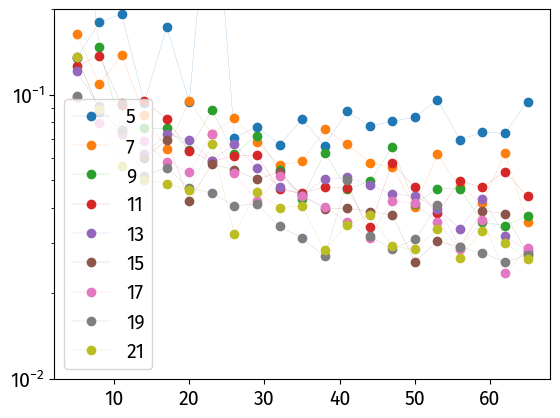

In [24]:
j = 0 
for i in np.transpose(phase_uncertainty_avg):

    plt.plot(avgs_set,i,label = '%d'%(n_points_set[j]),marker = 'o',linewidth = 0.1)
    j+=1 
    
plt.legend()
plt.yscale('log')
plt.ylim(0.01,0.2)

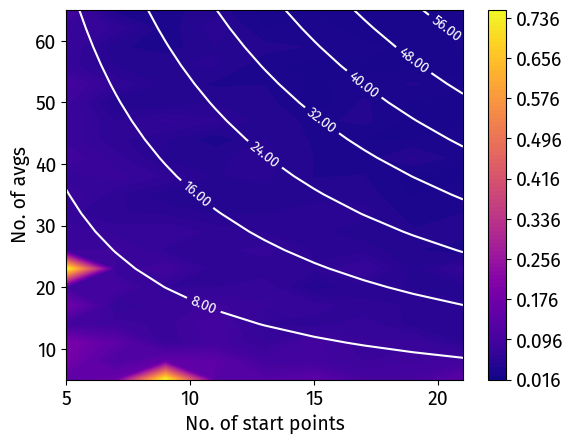

In [25]:
fig, ax = plt.subplots()

# draw contour


# add labels inside contour lines


C1 = ax.contourf(X,Y,phase_uncertainty_avg,cmap = 'plasma',levels = 100)
fig.colorbar(C1, ax=ax)
cs = ax.contour(X,Y,measurement_time,colors='white')
ax.clabel(cs, inline=True, fontsize=10, fmt="%.2f")
# plt.figure()
# C1 = plt.contourf(X,Y,(phase_error_mat+X/X)%np.pi-(X/X),cmap = 'plasma',levels = 200)




plt.xlabel('No. of start points')
plt.ylabel('No. of avgs')
plt.savefig('phase_error.pdf')


  0%|          | 0/20 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

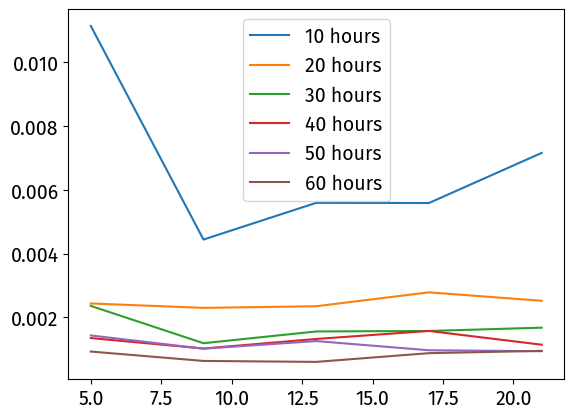

In [8]:
measurement_hours = [10,20,30,40,50,60]

for m in measurement_hours:
    
    measurement_time = m*3600

    n_points_set = np.linspace(5,21,5)
    avgs_set = (measurement_time/(T*n_points_set)).astype(np.int32)
    N_runs = 20
    phase_uncertainty = n_points_set*0
    phase_error = n_points_set*0
    phase_uncertainty_avg = n_points_set*0
    phase_error_avg = n_points_set*0

    for i in tqdm(range(N_runs)):
        j = 0
        for (n_points,avgs) in tqdm(zip(n_points_set,avgs_set), leave = False):
            phi = np.random.rand(1)*2*np.pi
            t0,phis_measured,phis_err =estimate_phase(T,int(n_points),int(avgs),phi,N = 1e7,offset = np.pi/10)
            t_s = np.linspace(0,T-T/n_points,1000)
            sim_sig = []
            # plt.plot(t0,phis_measured)

            for t_i in t_s:
                sim_sig.append(signal(t_i,phi = phi))
            try:
                phase_uncertainty[j] = fit_sine(t0,phis_measured,phis_err)['phase_err']
                phase_error[j] = (fit_sine(t0,phis_measured,phis_err)['phase']-fit_sine(t_s,np.array(sim_sig))['phase'])
                phase_error[j]  = ((phase_error[j] +1)%np.pi-1)
            except:
                phase_uncertainty[j] = np.pi
                phase_error[j] = np.pi
                print('fit convergence failed')
            j+=1                    
           

        phase_uncertainty_avg+=(phase_uncertainty**2)
        phase_error_avg+=(phase_error**2)

    plt.plot(n_points_set,phase_uncertainty_avg/N_runs, label = '%d hours'%m)
    np.savetxt('%d hours_uncertainty.txt'%m,[n_points_set,np.sqrt(phase_uncertainty_avg)/N_runs])
    np.savetxt('%d hours_true_error.txt'%m,[n_points_set,np.sqrt(phase_error_avg)/N_runs])

    # plt.plot(n_points_set,phase_error_avg/N_runs)
plt.legend()

In [28]:
phase_error_avg

array([0., 0., 0., 0., 0.])

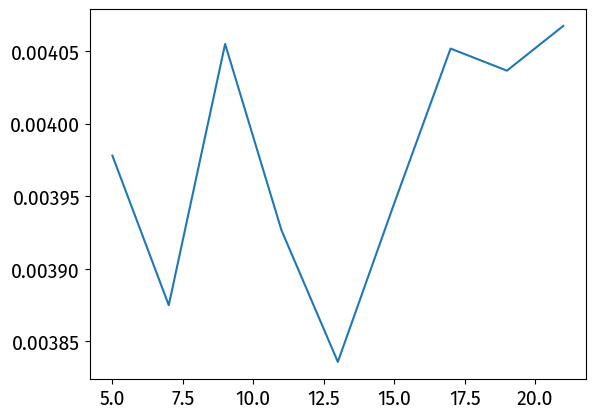

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

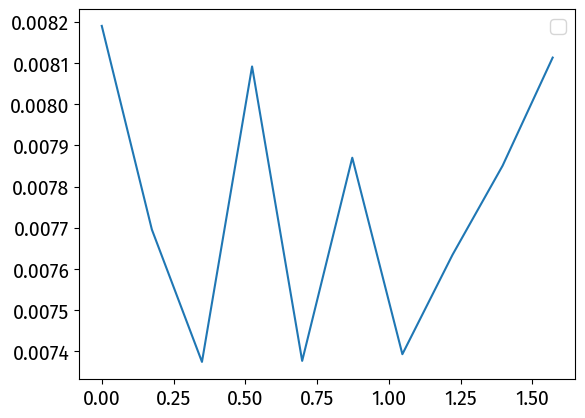

In [46]:
measurement_hours = 40

offsets = np.linspace(0,np.pi/2,10)
phase_uncertainty_offset = offsets*0
phase_error_offset= offsets*0
j = 0 
for offset in tqdm(offsets):
    
    measurement_time = measurement_hours*3600

    n_points = 15
    avgs = int(measurement_time/(T*n_points))
    N_runs = 20
  
    phase_uncertainty_avg = 0 
    phase_error_avg =0
    for i in tqdm(range(N_runs)):
        
        phi = np.random.rand(1)*2*np.pi
        t0,phis_measured,phis_err =estimate_phase(T,int(n_points),int(avgs),phi,N = 1e7,offset = np.pi/10)
        t_s = np.linspace(0,T-T/n_points,1000)
        sim_sig = []
        # plt.plot(t0,phis_measured)

        for t_i in t_s:
            sim_sig.append(signal(t_i,phi = phi))
        try:
            phase_uncertainty = fit_sine(t0,phis_measured,phis_err)['phase_err']
            phase_error = (fit_sine(t0,phis_measured,phis_err)['phase']-fit_sine(t_s,np.array(sim_sig))['phase'])
            phase_error  = ((phase_error +1)%np.pi-1)
        except:
            phase_uncertainty = np.pi
            phase_error = np.pi
            print('fit convergence failed')



        phase_uncertainty_avg+=(phase_uncertainty**2)
        phase_error_avg+=(phase_error**2)
    
    phase_uncertainty_offset[j] = np.sqrt(phase_uncertainty_avg)/N_runs
    phase_error_offset[j] = np.sqrt(phase_error_avg)/N_runs
    j+=1
    
plt.plot(offsets,phase_uncertainty_offset)
# plt.plot(offset,phase_uncertainty_avg/N_runs, label = '%d hours'%m)
np.savetxt('offsets.txt',[offsets,phase_uncertainty_offset])
plt.legend()

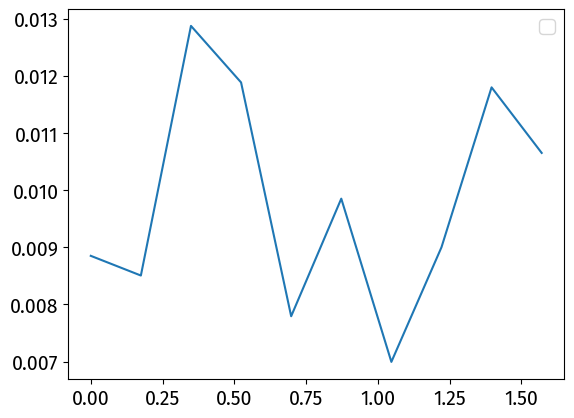

In [47]:
plt.plot(offsets,phase_error_offset)
# plt.plot(offset,phase_uncertainty_avg/N_runs, label = '%d hours'%m)
np.savetxt('offsets_errors.txt',[offsets,phase_error_offset])
plt.legend()